<a href="https://colab.research.google.com/github/GeorgiosLymperis/Quotes-classification-app/blob/master/python/bert_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Imports
In this section, we import the core libraries used for data handling, visualization, model training, and evaluation.


In [ ]:
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import squarify

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import RandomOverSampler


import torch
from datasets import Dataset
from transformers import (
    Trainer, TrainingArguments, EarlyStoppingCallback, pipeline,
    AutoTokenizer, AutoModelForSequenceClassification
)

np.random.seed(42)
torch.manual_seed(42)

sns.set_style("darkgrid")

2025-10-11 19:44:53.296867: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-11 19:44:55.274564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-11 19:44:59.433132: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Setting fixed random seeds ensures partial reproducibility across runs.  

In [ ]:
def make_pretty(styler):
    """
    Apply consistent visual styling to pandas Styler objects for cleaner notebook display.

    Args:
        styler: A pandas Styler object to format.

    Returns:
        The styled object with updated CSS properties and formatting.
    """
    styler.set_properties(**{'border': "1px solid", 'text-align': 'left'})
    styler.format(precision=3)
    return styler

## EDA
First, we load the dataset containing quotes and their associated topics

> **Note:**  
> Dataset compiled from publicly available quotes for educational use under fair use.  
> Not for redistribution.


In [ ]:
data = pd.read_csv("dataset.csv")
data.sample(5).style.pipe(make_pretty)

,quote,topic
4832,"I have a fundamental belief in the Bible as the Word of God, written by those who were inspired. I study the Bible daily.",Bible
5613,"The most precious gift we can offer anyone is our attention. When mindfulness embraces those we love, they will bloom like flowers.",Love
6123,Joy is the infallible sign of the presence of God.,Peace
2304,"I became more courageous by doing the very things I needed to be courageous for-first, a little, and badly. Then, bit by bit, more and better. Being avidly-sometimes annoy-ingly-curious and persistent about discovering how others were doing what I wanted to do.",Courage
5825,Love is just a word until someone comes along and gives it meaning.,Relationship


# Cleaning
Before we start the analysis, we check the dataset for missing values and duplicated quotes.

In [ ]:
print(f"The number of quotes is {data.shape[0]}")
print(f"The number of nans is {data.isna().sum().sum()}")
print(f"The number of duplicates is {data.duplicated().sum()}")

The number of quotes is 6525
The number of nans is 0
The number of duplicates is 716


In [ ]:
data = data.drop_duplicates()
print(f"After dropping duplicates, the number of quotes is {data.shape[0]}")

After dropping duplicates, the number of quotes is 5809


* Out of 6,525 quotes, 716 were exact duplicates.
* After removing them, 5,809 unique quotes remain.  
* No missing values were found.

In [ ]:
data.duplicated(subset='quote').sum()

np.int64(194)

There are 194 quotes that are duplicated with different topics.

In [ ]:
conflicts = data[data.duplicated(subset='quote', keep=False)].sort_values('quote')
conflicts.head(10).style.pipe(make_pretty)

,quote,topic
5122,A bank is a place that will lend you money if you can prove that you don't need it.,Money
4740,A bank is a place that will lend you money if you can prove that you don't need it.,Funny
6440,"A failure is like fertilizer; it stinks to be sure, but it makes things grow faster in the future.",Success
4172,"A failure is like fertilizer; it stinks to be sure, but it makes things grow faster in the future.",Inspirational
1492,A great obstacle to happiness is to expect too much happiness.,Positive
1490,A great obstacle to happiness is to expect too much happiness.,Happiness
928,A happy life consists in tranquility of mind.,Happiness
937,A happy life consists in tranquility of mind.,Positive
3522,A man's as miserable as he thinks he is.,Happiness
3525,A man's as miserable as he thinks he is.,Positive


We can see examples where the same quote is categorized under multiple topics, such as:
- “A bank is a place that will lend you money if you can prove that you don’t need it.” → *Money* and *Funny*
- “A failure is like fertilizer...” → *Success* and *Inspirational*

This overlap makes it difficult to determine a single ground-truth label.
For the current task, we will treat each unique quote as a single example and keep only its first occurrence.

In [ ]:
data = data.drop_duplicates(subset='quote', keep='first')
print(f"After dropping duplicates, the number of quotes is {data.shape[0]}")

After dropping duplicates, the number of quotes is 5615


# Visuals

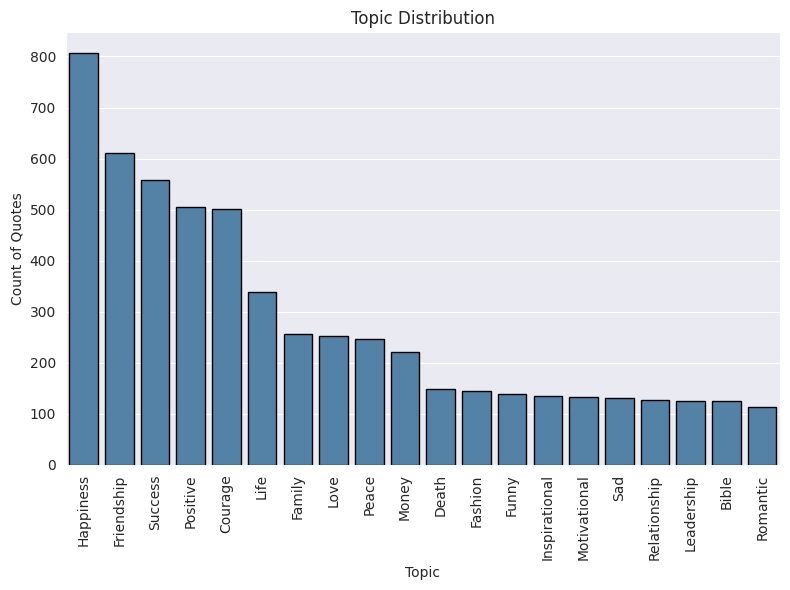

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='topic', order=data['topic'].value_counts().index, color='steelblue', edgecolor='black')
plt.title("Topic Distribution")
plt.xlabel("Topic")
plt.ylabel("Count of Quotes")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


We have an imbalanced dataset. Categories such as *Happiness*, *Friendship*, and *Success* are more popular. On the other hand the categories *Leadership*, *Bible* and *Romantic* is less popular.
This imbalance can bias the model toward the majority topics.

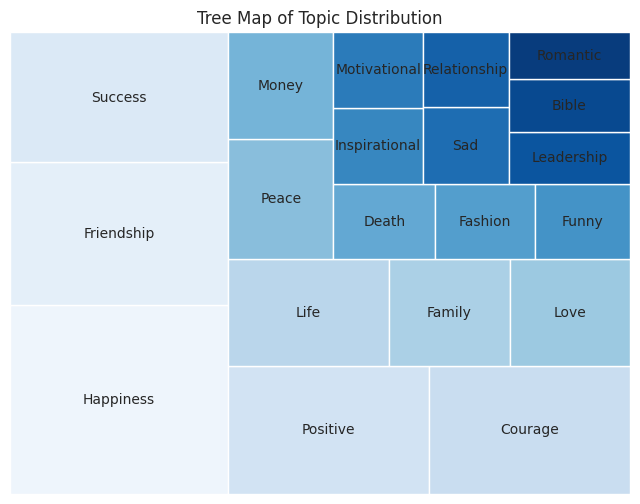

In [ ]:
plt.figure(figsize=(8, 6))
squarify.plot(sizes=data['topic'].value_counts().values, label=data['topic'].value_counts().index, color=sns.color_palette("Blues", data['topic'].value_counts().shape[0]))
plt.title("Tree Map of Topic Distribution")
plt.axis('off')
plt.show()

The treemap highlights that a few large categories occupy most of the dataset, while smaller ones make up only a fraction of total samples

Before tokenization, it's useful to understand how long the quotes are. This helps decide the maximum sequence length for BERT and ensures that truncation doesn't remove too much information.

In [ ]:
data['word count'] = data['quote'].apply(lambda x: len(x.split()))
print("Descriptive statistics of word count:")
data['word count'].describe().to_frame().T.style.pipe(make_pretty)

Descriptive statistics of word count:


,count,mean,std,min,25%,50%,75%,max
word count,5615.000,19.591,13.408,2.000,11.000,16.000,23.000,210.000


The majority of quotes contain between 10 and 25 words, with a long tail up to 210 words.

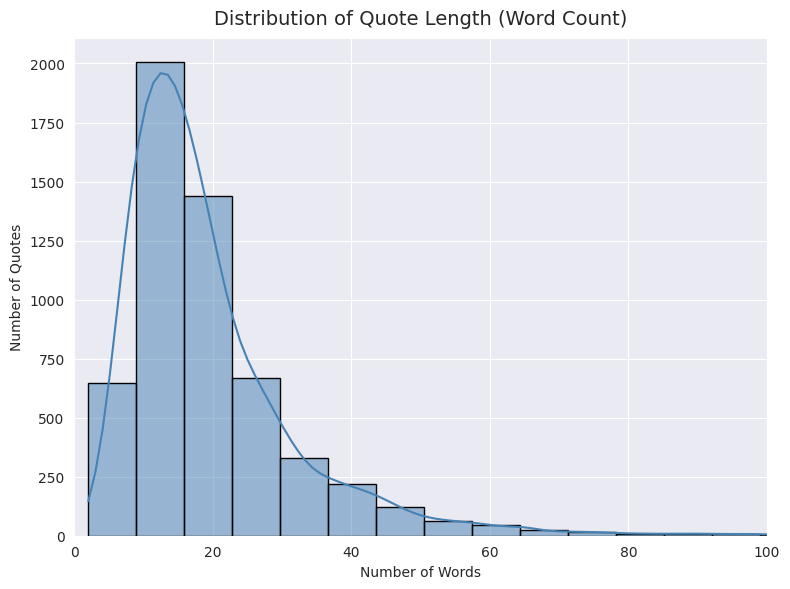

In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(
    data=data, x='word count',
    bins=30, kde=True,
    color='steelblue', edgecolor='black'
)
plt.title("Distribution of Quote Length (Word Count)", fontsize=14, pad=10)
plt.xlabel("Number of Words")
plt.ylabel("Number of Quotes")
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


Most quotes are short, typically fewer than 25 words.  
Given that BERT tokenization often produces about 1.3–1.5 tokens per word,  
a maximum sequence length of 512 tokens will comfortably cover almost all examples without truncating information.

This informs the model configuration used later in fine-tuning.

In [ ]:
TOKENS = 512
threshold = TOKENS / 1.3
pct = (data['word count'] <= threshold).mean() * 100
print(f"{pct:.2f}% of quotes would fit within {TOKENS} BERT tokens.")

100.00% of quotes would fit within 512 BERT tokens.


## Train–Validation–Test Split
To train and evaluate the model, we divide the dataset into training, validation, and test sets.

In [ ]:
# Split data: small training set due to limited resources
train_df, temp_df = train_test_split(data, test_size=0.8, random_state=42, stratify=data['topic'])

# Split remaining data into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=0.3, random_state=42, stratify=temp_df['topic'])

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 1123
Validation size: 3144
Test size: 1348


BERT requires numeric labels for classification.  
We create mappings between each topic and its corresponding integer ID, ensuring consistent encoding across training, validation, and test splits.

In [ ]:
TOPICS = [
    "Love", "Funny", "Inspirational", "Friendship", "Life", "Motivational",
    "Sad", "Leadership", "Family", "Romantic", "Happiness", "Positive",
    "Success", "Death", "Relationship", "Bible", "Peace", "Fashion",
    "Courage", "Money"
]

# Create label mappings
label2id = {lbl: i for i, lbl in enumerate(TOPICS)}
id2label = {i: lbl for lbl, i in label2id.items()}

# Apply label encoding
train_df["label"] = train_df['topic'].map(label2id)
val_df["label"] = val_df['topic'].map(label2id)
test_df["label"] = test_df['topic'].map(label2id)

train_df[['topic', 'label']].head().style.pipe(make_pretty)

,topic,label
3981,Success,12
4356,Family,8
6005,Romantic,9
4465,Fashion,17
711,Happiness,10


# Handling Class Imbalance

The dataset is imbalanced — some topics like *Happiness* and *Friendship* dominate, while others (e.g., *Bible*, *Romantic*) are underrepresented.  

To help the model learn minority classes better, we apply random oversampling on the training set. This duplicates examples from minority topics until all classes have equal representation.


In [ ]:
# Separate features and labels
X = train_df[['quote']]
y = train_df[['label']]

# Apply random oversampling
sampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = sampler.fit_resample(X, y)

train_df_resampled = pd.DataFrame({
    "text": X_resampled["quote"].values,
    "label": y_resampled.values.reshape(-1)
})

print(f"Original training size: {len(train_df)}")
print(f"Resampled training size: {len(train_df_resampled)}")

Original training size: 1123
Resampled training size: 3220


> **Note:**  
> Oversampling improves representation of rare classes but increases the risk of overfitting,  
> since some minority examples are repeated.  
> In future iterations, more advanced techniques such as *data augmentation* or *class-weighted loss functions* could be explored.


In [ ]:
val_df_fixed = pd.DataFrame({
    "text": val_df["quote"].tolist(),
    "label": val_df["label"].tolist()
})
test_df_fixed = pd.DataFrame({
    "text": test_df["quote"].tolist(),
    "label": test_df["label"].tolist()
})

print(f"Validation size: {len(val_df_fixed)}")
print(f"Test size: {len(test_df_fixed)}")

Validation size: 3144
Test size: 1348


In [ ]:
train_dataset = Dataset.from_pandas(train_df_resampled)  # columns: text, label
val_dataset = Dataset.from_pandas(val_df_fixed)
test_dataset = Dataset.from_pandas(test_df_fixed)

## BERT Training

We use **BERT-base (uncased)** from the Hugging Face Transformers library.  
This model has 12 transformer layers and 110M parameters, pretrained on large English text corpora.  
It provides strong generalization for text classification tasks such as topic prediction.


In [ ]:
# Define pretrained model checkpoint
model_name = "bert-base-uncased"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Load model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

We initialize the model with 20 output labels corresponding to the defined topic categories.  
The mappings `label2id` and `id2label` ensure that the model’s predictions can be interpreted correctly during evaluation.

Next, we tokenize the text data for input into BERT.  
Tokenization converts raw text into input IDs and attention masks that BERT can understand.  
Padding and truncation are applied to ensure uniform sequence lengths across samples.

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples['text'],              # column containing text
        padding="max_length",          # pad all sequences to the same length
        truncation=True,               # truncate longer sequences
        max_length=512                 # maximum token length for BERT
    )

train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

# HF expects the target column to be named "labels"
train_tokenized = train_tokenized.rename_column("label", "labels")
val_tokenized = val_tokenized.rename_column("label", "labels")
test_tokenized = test_tokenized.rename_column("label", "labels")

# set tensor format
train_tokenized.set_format("torch")
val_tokenized.set_format("torch")
test_tokenized.set_format("torch")



Each quote is now represented as a sequence of token IDs (integers) along with attention masks.  
We use a maximum sequence length of 512 tokens, which fully covers the dataset (based on our earlier quote-length analysis).  

Padding ensures all sequences are of equal length for batch processing,  
and truncation safely handles the long quotes that may exceed the limit.

In [ ]:
# Define training arguments for fine-tuning the BERT model
training_args = TrainingArguments(
    output_dir="./model",                  # Directory to store model checkpoints and outputs
    eval_strategy="epoch",                 # Evaluate the model at the end of each epoch
    learning_rate=2e-5,                    # Learning rate for AdamW optimizer
    per_device_train_batch_size=8,         # Batch size per device
    num_train_epochs=10,                   # Total number of training epochs
    weight_decay=0.01,                     # Weight decay for regularization
    logging_dir="./logs",                  # Directory to save training logs
    logging_steps=10,                      # Log metrics every 10 steps
    save_strategy="epoch",                 # Save model checkpoint at the end of each epoch
    load_best_model_at_end=True,           # Load the best model based on eval metric after training
    metric_for_best_model="f1_macro",      # Metric to determine the best model
    greater_is_better=True,                # Higher F1 score is better
    save_total_limit=2,                    # Keep only the last 2 checkpoints
    run_name="bert_quote_classification"   # Name for experiment tracking/logging
)

# Define early stopping callback — stop training when performance stops improving
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,             # Number of epochs without improvement before stopping
    early_stopping_threshold=0.001         # Minimum improvement threshold to count as progress
)

# Define metric computation function for validation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# Initialize the Trainer — handles training, evaluation, and checkpointing
trainer = Trainer(
    model=model,                           # The model to be fine-tuned
    args=training_args,                    # Training configuration defined above
    train_dataset=train_tokenized,         # Tokenized training dataset
    eval_dataset=val_tokenized,            # Tokenized validation dataset
    compute_metrics=compute_metrics,       # Evaluation metrics function
    callbacks=[early_stopping]             # Early stopping callback
)


We now fine-tune the BERT model on the training dataset.  
The validation set is evaluated at the end of each epoch, and early stopping is applied if performance plateaus.  
The best model (based on macro-F1) is automatically reloaded after training.

In [ ]:
# We train the model
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: puaphantom (puaphantom-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.161500,1.543332,0.588422,0.547391,0.593037
2,0.366700,1.447700,0.610369,0.576370,0.614353
3,0.185000,1.715775,0.610051,0.568210,0.607926
4,0.099200,1.880174,0.610687,0.570816,0.607511


TrainOutput(global_step=1612, training_loss=0.7281096564656674, metrics={'train_runtime': 1628.8811, 'train_samples_per_second': 19.768, 'train_steps_per_second': 2.474, 'total_flos': 3389418084433920.0, 'train_loss': 0.7281096564656674, 'epoch': 4.0})

### Training Summary

- Best validation macro-F1: 0.61  
- Early stopping triggered after: 4 epochs  
- Training completed in approximately 40 minutes on a T4 GPU (Google Colab).


## Model Evaluation

After training, we evaluate the final model on the held-out test set.  
This dataset was not used during training or validation, ensuring an unbiased estimate of real-world performance.  
We report per-class precision, recall, and F1-scores to assess how well the model performs across all 20 topics.


In [ ]:
logits, labels, _ = trainer.predict(test_tokenized)
preds = np.argmax(logits, axis=-1)

print("\nClassification report (test):")
print(classification_report(labels, preds, target_names=TOPICS, digits=3))


Classification report (test):
               precision    recall  f1-score   support

         Love      0.524     0.705     0.601        61
        Funny      0.308     0.364     0.333        33
Inspirational      0.148     0.281     0.194        32
   Friendship      0.774     0.816     0.795       147
         Life      0.370     0.333     0.351        81
 Motivational      0.116     0.156     0.133        32
          Sad      0.471     0.516     0.492        31
   Leadership      0.750     0.500     0.600        30
       Family      0.652     0.705     0.677        61
     Romantic      0.600     0.444     0.511        27
    Happiness      0.715     0.686     0.700       194
     Positive      0.263     0.215     0.236       121
      Success      0.654     0.619     0.636       134
        Death      0.722     0.722     0.722        36
 Relationship      0.361     0.433     0.394        30
        Bible      0.920     0.767     0.836        30
        Peace      0.540     0.45

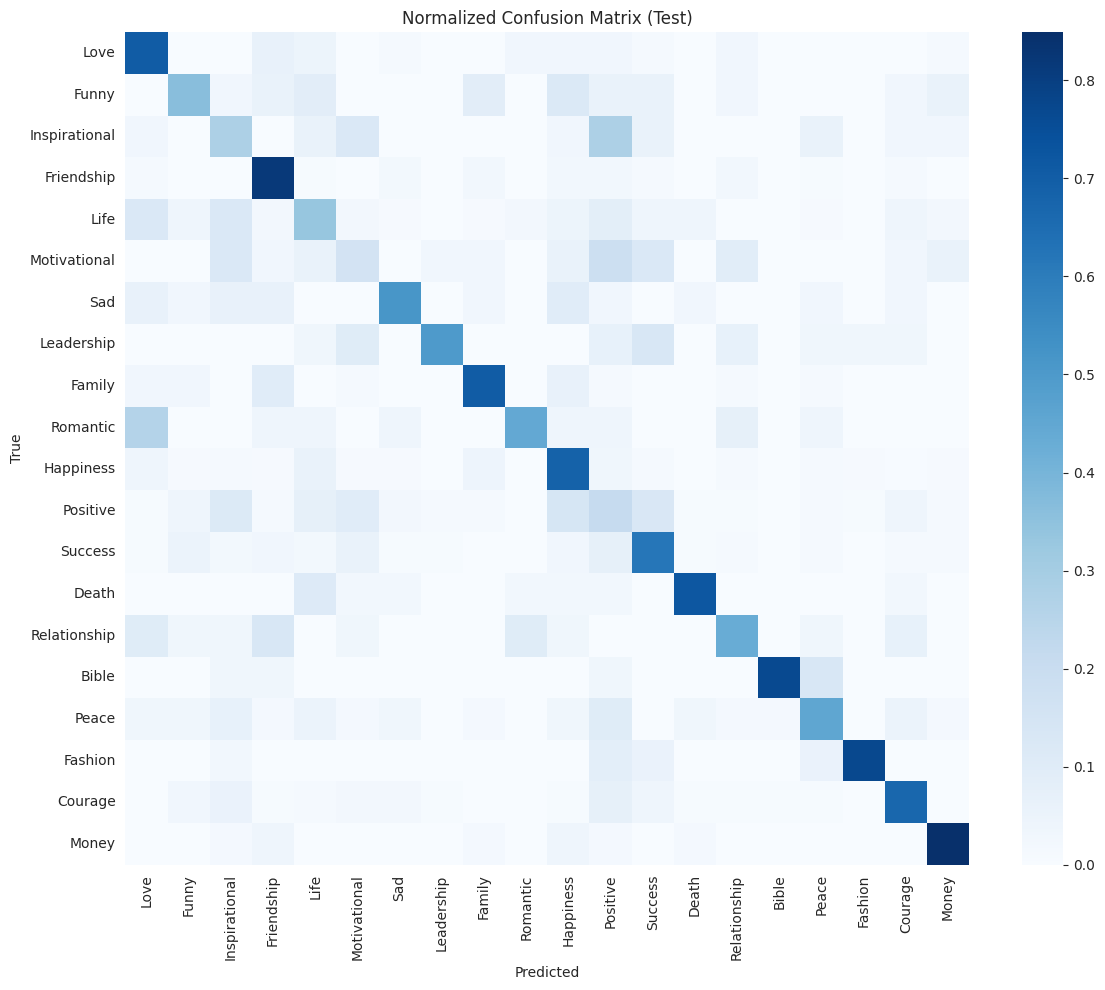

In [ ]:
cm = confusion_matrix(labels, preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=False, cmap="Blues",
            xticklabels=TOPICS, yticklabels=TOPICS)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

Confusion often occurs between topics with similar meanings or emotional contexts.
For example:
- **Love**: Is confused with **Romantic** and **Relationship**.
- **Motivational**: Is confused with **Inspirational** and **Positive**.
- **Life**: Is confused with **Love** and **Inspirational**.

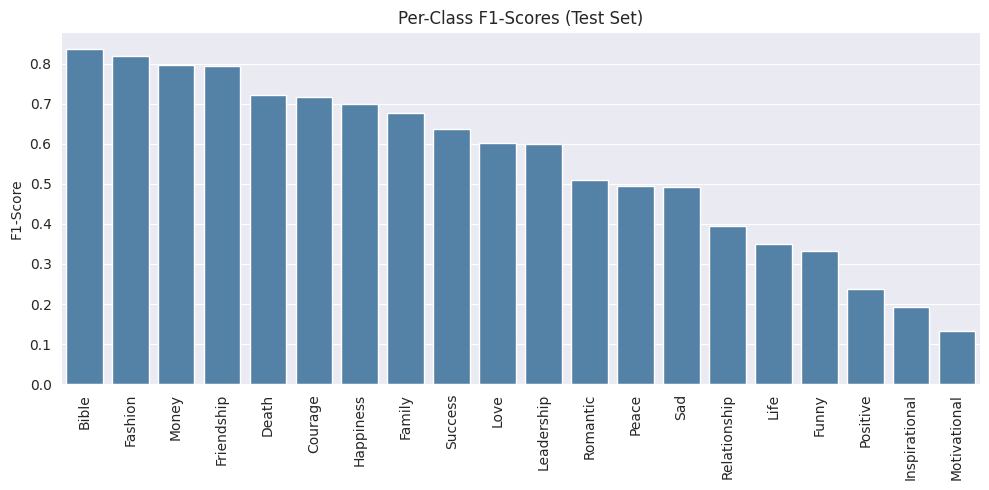

In [ ]:
report = classification_report(labels, preds, target_names=TOPICS, output_dict=True)
f1_scores = {k: v['f1-score'] for k, v in report.items() if k in TOPICS}
f1_scores = dict(sorted(f1_scores.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10,5))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), color='steelblue')
plt.xticks(rotation=90)
plt.ylabel("F1-Score")
plt.title("Per-Class F1-Scores (Test Set)")
plt.tight_layout()
plt.show()

### Summary

- **Overall accuracy:** 0.58  
- **Macro-F1:** 0.55
- **Weighted-F1:** 0.59

Performance varies across topics:
- Strong results for **Bible (F1=0.84)**, **Fashion (0.82)**, and **Money (0.80)** — topics with clearer linguistic cues.
- Lower performance for abstract or overlapping categories such as **Motivational (0.13)**, **Inspirational (0.194)**, and **Positive (0.24)**.
- The gap between macro and weighted F1 indicates the impact of class imbalance despite oversampling.


In [ ]:
trainer.save_model("./results/final_model")
tokenizer.save_pretrained("./results/final_model")

('./results/final_model/tokenizer_config.json',
 './results/final_model/special_tokens_map.json',
 './results/final_model/vocab.txt',
 './results/final_model/added_tokens.json',
 './results/final_model/tokenizer.json')

In [ ]:
with open("./results/final_model/label_mapping.json", "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, indent=2)

print("\nModel saved to ./results/final_model")


Model saved to ./results/final_model


## Model Inference

Finally, we load the saved model and tokenizer to make predictions on new, unseen quotes.  
This verifies that the fine-tuned BERT model can be easily reused for deployment or integration into an application backend.


In [ ]:
model_dir = "./results/final_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(model_dir, output_attentions=True).eval()
with open(f"{model_dir}/label_mapping.json") as f:
    m = json.load(f)
id2label = {int(k): v for k, v in m["id2label"].items()}

texts = [
    "Love is friendship set on fire."
]

inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
with torch.no_grad():
    out = model(**inputs)
logits = out.logits
probs = torch.softmax(logits, dim=-1).cpu().numpy()
preds = probs.argmax(axis=-1)

for t, p, pr in zip(texts, preds, probs):
    print(t, "->", id2label[int(p)], f"(conf {pr[int(p)]:.3f})")


Love is friendship set on fire. -> Friendship (conf 0.931)


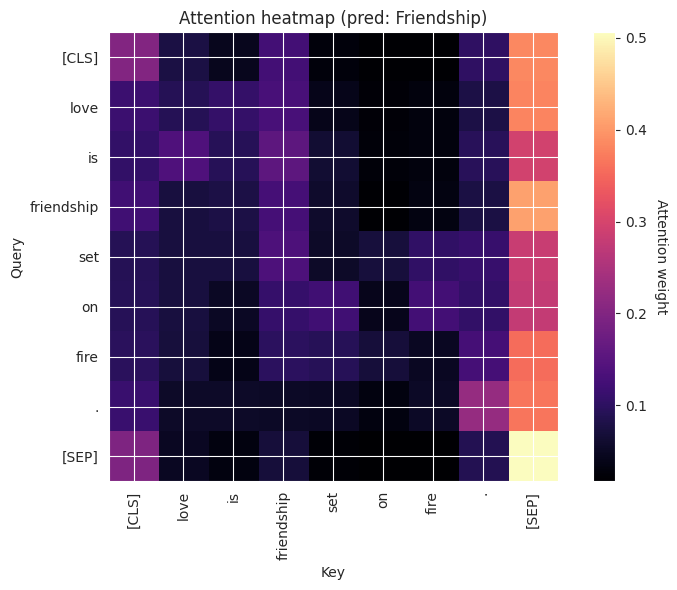

In [ ]:
# attentions: list[L] of (1, H, T, T)
atts = [a.squeeze(0).cpu().numpy() for a in out.attentions]  # -> list (H,T,T)
layer_avg = [a.mean(0) for a in atts]                        # list of (T,T)
attn_map = np.mean(np.stack(layer_avg, 0), 0)                # (T,T)

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(attn_map, cmap="magma")

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Attention weight", rotation=270, labelpad=15)

# Configure ticks and labels
ax.set_xticks(range(len(tokens)))
ax.set_yticks(range(len(tokens)))
ax.set_xticklabels(tokens, rotation=90)
ax.set_yticklabels(tokens)

# Titles and labels
ax.set_title(f"Attention heatmap (pred: {id2label[preds[0]]})")
ax.set_xlabel("Key")
ax.set_ylabel("Query")

plt.tight_layout()
plt.show()


The attention heatmap shows how the model distributes focus across tokens during prediction.
- **“Love”** and **“friendship”** receive stronger attention weights, indicating that the model identifies them as important to the final classification.
- This example also illustrates semantic overlap between categories. The sentence could reasonably fit under both *Love* and *Friendship*.


In [ ]:
clf = pipeline("text-classification", model="./results/final_model", tokenizer="./results/final_model",
               top_k=None, function_to_apply="softmax", truncation=True)
print(clf("Love is friendship set on fire."))


Device set to use cuda:0


[[{'label': 'Friendship', 'score': 0.9306497573852539}, {'label': 'Love', 'score': 0.015491890721023083}, {'label': 'Relationship', 'score': 0.008365738205611706}, {'label': 'Peace', 'score': 0.005673070903867483}, {'label': 'Success', 'score': 0.0037676868960261345}, {'label': 'Sad', 'score': 0.00358365336433053}, {'label': 'Life', 'score': 0.0033475300297141075}, {'label': 'Bible', 'score': 0.0032838366460055113}, {'label': 'Death', 'score': 0.003278626361861825}, {'label': 'Money', 'score': 0.003184159053489566}, {'label': 'Funny', 'score': 0.003016407834365964}, {'label': 'Happiness', 'score': 0.0028590853326022625}, {'label': 'Leadership', 'score': 0.0026889846194535494}, {'label': 'Positive', 'score': 0.002300729276612401}, {'label': 'Family', 'score': 0.0022492490243166685}, {'label': 'Courage', 'score': 0.0019318158738315105}, {'label': 'Fashion', 'score': 0.0017413691384717822}, {'label': 'Romantic', 'score': 0.0016143659595400095}, {'label': 'Inspirational', 'score': 0.000658

## Final Remarks

This project demonstrates the end-to-end process of fine-tuning a pretrained BERT model for quote topic classification:

1. **Data Understanding** – Cleaning, deduplication, and exploratory analysis to identify class imbalance and text length patterns.  
2. **Modeling** – Fine-tuning BERT-base (uncased) with early stopping and macro-F1 as the key evaluation metric.  
3. **Evaluation** – Achieved macro-F1 =0.55 on 20 diverse topics, with strongest performance on clear thematic categories.  
4. **Deployment Readiness** – The trained model can be reloaded and used for inference with minimal setup.

**Next steps:**  
- Collect additional data for minority classes.  
- Explore *DistilBERT* or *RoBERTa* for efficiency and performance trade-offs.  
- Package the model behind an API for integration into an quote classification app.